# Logistic Regression from Scratch

This project implements logistic regression from scratch using batch gradient descent.
The goal is to understand the full binary classification pipeline — from log-loss optimization and L2 regularization to handling class imbalance and decision threshold tuning — without relying on high-level machine learning libraries.

The workflow includes feature engineering based on domain insights, class weighting for imbalanced data, hyperparameter tuning (learning rate and regularization strength), ROC-AUC and F1-based evaluation, threshold optimization, and analysis through ROC, Precision–Recall curves, and confusion matrix.

Finally, the custom implementation is compared against Scikit-learn’s **LogisticRegression** to validate correctness, stability, and overall performance.

## Dataset

This project uses the **Default of Credit Card Clients** dataset (Taiwan, 2005) from the 
[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients).

Each row represents a credit card client and includes: Demographic information (e.g., sex, education, marriage status), credit limit, historical billing statements, repayment behavior over the past months.

The target variable is binary:

- **1 = default** (client fails to make the required payment in the following month)
- **0 = no default**

The dataset contains **30,000 observations** with a mix of numerical and categorical features, making it a realistic benchmark for implementing logistic regression from scratch and evaluating it using metrics such as log-loss, accuracy, and ROC-AUC.

In [1]:
import sys
sys.path.append("..")

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Project modules
from src.model import LogisticRegressionScratch
from src.preprocessing import train_val_test_split, fit_zscore, transform_zscore
from src.plotting import roc_curve_plot, precision_recall_curve_plot

### Data loading and inspection

We load the dataset and perform basic exploratory checks to understand its structure and quality.

- *df.shape* — verifies the dataset size (number of rows and columns).
- *df.head()* — previews the first few observations to inspect column names and raw values.
- *df.info()* — checks data types and confirms whether any columns were incorrectly parsed.
- *df.isna().sum().sort_values(ascending=False).head(10)* — identifies missing values and highlights columns with the highest number of null entries.

In [2]:
df = pd.read_csv("../data/default of credit card clients.csv", index_col=0, header=1)
df.shape
df.info()
df.isna().sum().sort_values(ascending=False).head(10)
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_AMT4  

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Data preprocessing

- Categorical features **EDUCATION** and **MARRIAGE** are converted using one-hot encoding (with *drop_first=True* to avoid multicollinearity).

- The target variable is separated from the input features and converted to integer format.

- The dataset is then split into training, validation, and test sets (70% / 15% / 15%).

- Z-score normalization is applied **only to continuous numerical features**, excluding one-hot encoded columns. 

- The mean and standard deviation are computed on the training set and reused for validation and test sets to prevent data leakage.

In [3]:
df = pd.get_dummies(
    df,
    columns=["EDUCATION", "MARRIAGE"],
    drop_first=True
)

X = df.drop(columns=["default payment next month"])
y = df["default payment next month"].to_numpy().astype(int)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    X.to_numpy(), y, 0.7, 0.15, 52
)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val,   columns=X.columns)
X_test_df = pd.DataFrame(X_test,  columns=X.columns)

numeric_cols = X.select_dtypes(include=["int64", "float64", "uint8", "bool"]).columns
numeric_cols = [c for c in numeric_cols
                if not (c.startswith("EDUCATION_") or c.startswith("MARRIAGE_"))]

mu, std = fit_zscore(X_train_df[numeric_cols].to_numpy(dtype=float))

for d in (X_train_df, X_val_df, X_test_df):
    d.loc[:, numeric_cols] = transform_zscore(d.loc[:, numeric_cols].to_numpy(dtype=float), mu, std)

X_train = X_train_df.to_numpy(dtype=float)
X_val = X_val_df.to_numpy(dtype=float)
X_test = X_test_df.to_numpy(dtype=float)

## Class balance analysis

Before training the model, we analyze the distribution of the target variable.

Since this is a credit risk dataset, class imbalance is expected:
most clients do not default, while defaults represent a minority class.

Understanding the class distribution is important because accuracy alone
may be misleading in imbalanced classification problems.

Class counts:
0    23364
1     6636
Name: count, dtype: int64

Class ratios:
0    0.7788
1    0.2212
Name: proportion, dtype: float64


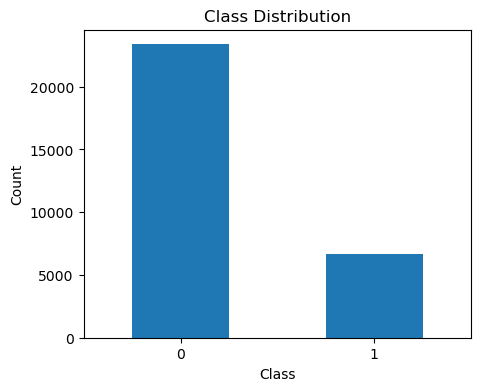

In [4]:
class_counts = pd.Series(y).value_counts() # Class distribution
class_ratio = pd.Series(y).value_counts(normalize=True)

print("Class counts:")
print(class_counts)
print("\nClass ratios:")
print(class_ratio)

plt.figure(figsize=(5,4))
class_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

## Baseline logistic regression model evaluation and visualization

We train logistic regression using batch gradient descent and optimize the binary cross-entropy (log-loss) objective.

Model performance is evaluated using the following metrics:



### Accuracy

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

Overall proportion of correctly classified samples.



### Precision

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Among predicted defaulters, how many are truly defaulters.



### Recall

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Among all actual defaulters, how many the model successfully identifies.



### F1-score

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Harmonic mean of precision and recall, balancing false positives and false negatives.


### ROC curve and ROC–AUC

The **ROC curve (Receiver Operating Characteristic)** is constructed by:

- Varying the classification threshold from 0 to 1  
- Computing:
  $$
  TPR = \frac{TP}{TP + FN}
  $$
  $$
  FPR = \frac{FP}{FP + TN}
  $$
- Plotting TPR against FPR for each threshold

The **AUC (Area Under the Curve)** is the area under the ROC curve.  
It measures how well the model separates positive and negative classes across all possible thresholds.

In [5]:
model = LogisticRegressionScratch(alpha=0.01, num_iters=2000)
model.fit(X_train, y_train)
y_pred = model.predict(X_val, threshold=0.5)
y_proba = model.predict_proba(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))

Accuracy: 0.8082222222222222
Precision: 0.7109634551495017
Recall: 0.21616161616161617
F1: 0.33152594887683967
ROC-AUC: 0.7297171141615586


### ROC-AUC curve

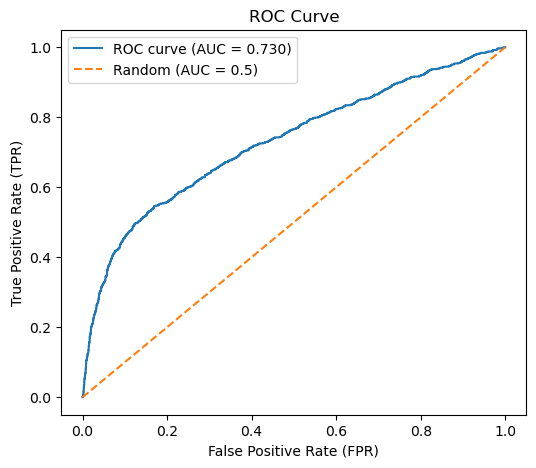

In [6]:
roc_curve_plot(y_val, y_proba)

#### Results and interpretation

The validation results show that **accuracy (≈ 0.81)** is relatively high.  
However, this metric is not fully representative because the dataset is imbalanced — the majority of clients do **not** default.  
The model can achieve high accuracy simply by predicting class 0 more often.

**Precision (≈ 0.71)** is reasonably good.  
When the model predicts a client will default, it is correct about 71% of the time.  
This is partly influenced by class imbalance — predicting fewer positives reduces false positives.

**Recall (≈ 0.22)** is very low.  
The model detects only about 22% of actual defaulters, meaning most risky clients are missed.  
For a credit risk problem, this is a serious limitation.

**F1-score (≈ 0.33)** is low because it balances precision and recall, and recall is weak.

**ROC–AUC (≈ 0.73)** suggests the model has moderate ranking ability — it can separate defaulters from non-defaulters better than random guessing (0.5), but there is significant room for improvement.

Overall, the baseline model tends to favor predicting non-default cases, which inflates accuracy but fails to adequately capture risky clients.

## Balanced class weighting
To address class imbalance, we train the model using balanced class weights.

For a dataset of size $m$, let  
$n_{pos}$ — number of positive samples (default = 1),  
$n_{neg}$ — number of negative samples (default = 0).

The class weights are computed as:

$$
w_{pos} = \frac{m}{2 \cdot n_{pos}}
$$

$$
w_{neg} = \frac{m}{2 \cdot n_{neg}}
$$

Each training sample receives a weight depending on its class:

$$
w_i =
\begin{cases}
w_{pos}, & \text{if } y_i = 1 \\
w_{neg}, & \text{if } y_i = 0
\end{cases}
$$

This increases the influence of the minority class during optimization and penalizes mistakes on defaulters more strongly.

Balanced class weighting encourages the model to better detect defaulters instead of favoring the majority (non-default) class.

In [7]:
model = LogisticRegressionScratch(alpha=0.01, num_iters=2000, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_val, threshold=0.5)
y_proba = model.predict_proba(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))

Accuracy: 0.6897777777777778
Precision: 0.38086854460093894
Recall: 0.6555555555555556
F1: 0.48181143281366
ROC-AUC: 0.7348582693027138


## Feature engineering
To better capture financial behavior patterns, several aggregated and ratio-based features are introduced:

- **MAX_BILL** - maximum monthly bill amount over the last 6 months.  
  Reflects peak credit usage.

- **DEBT_RATIO_MEAN** - average bill divided by credit limit.  
  Measures typical credit utilization level.

- **DEBT_RATIO_MAX** - maximum bill divided by credit limit.  
  Captures extreme over-utilization risk.

- **AVG_PAY_RATIO** - total payments divided by total billed amount.  
  Indicates how consistently the client repays outstanding balances.

- **AVG_DELAY** - average repayment delay across recent months.  
  Represents overall repayment discipline.

- **MAX_DELAY** - maximum observed repayment delay.  
  Captures worst historical delinquency behavior.

- **BILL_GROWTH** - average month-to-month change in bill amount.  
  Reflects whether debt is increasing over time.

In [8]:
bills = df.loc[:, ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]]
payments = df.loc[:, ["PAY_0","PAY_2","PAY_3","PAY_4","PAY_5","PAY_6"]]

df['MAX_BILL'] = bills.max(axis=1)
df["DEBT_RATIO_MEAN"] = bills.mean(axis=1) / (df["LIMIT_BAL"] + 1)
df["DEBT_RATIO_MAX"] = bills.max(axis=1) / (df["LIMIT_BAL"] + 1)
df["AVG_PAY_RATIO"] = (payments.sum(axis=1) / (bills.sum(axis=1) + 1))
df["AVG_DELAY"] = payments.mean(axis=1)
df["MAX_DELAY"] = payments.max(axis=1)
df["BILL_GROWTH"] = bills.diff(axis=1).mean(axis=1)

### Data preprocessing

In [9]:
X = df.drop(columns=["default payment next month"])
y = df["default payment next month"].to_numpy().astype(int)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(
    X.to_numpy(), y, 0.7, 0.15, 52
)

X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_val_df = pd.DataFrame(X_val,   columns=X.columns)
X_test_df = pd.DataFrame(X_test,  columns=X.columns)

numeric_cols = X.select_dtypes(include=["int64", "float64", "uint8", "bool"]).columns
numeric_cols = [c for c in numeric_cols
                if not (c.startswith("EDUCATION_") or c.startswith("MARRIAGE_"))]

mu, std = fit_zscore(X_train_df[numeric_cols].to_numpy(dtype=float))

for d in (X_train_df, X_val_df, X_test_df):
    d.loc[:, numeric_cols] = transform_zscore(d.loc[:, numeric_cols].to_numpy(dtype=float), mu, std)

X_train = X_train_df.to_numpy(dtype=float)
X_val = X_val_df.to_numpy(dtype=float)
X_test = X_test_df.to_numpy(dtype=float)

### Model training

In [10]:
model = LogisticRegressionScratch(alpha=0.01, num_iters=2000, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_val, threshold=0.5)
y_proba = model.predict_proba(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))

Accuracy: 0.7404444444444445
Precision: 0.4393732970027248
Recall: 0.6515151515151515
F1: 0.5248169243287225
ROC-AUC: 0.7538919105585772


#### Results and interpretation

After applying class balancing, the model shifts toward detecting more default cases.

- **Recall (0.65)** significantly improves compared to the baseline, meaning the model now detects a much larger share of actual defaulters.
- **Precision (0.44)** decreases, indicating more false positives - more non-defaulters are flagged as risky.
- **F1-score (0.52)** improves overall, showing a better balance between precision and recall.
- **ROC-AUC (0.754)** remains stable and slightly higher than before, meaning the model’s ranking ability is consistent.

Overall, class weighting makes the model more sensitive to the minority class (defaults), which is desirable in credit risk modeling where missing a defaulter is more costly than incorrectly flagging a reliable client.

## Hyperparameter tuning
Grid search using ROC-AUC to balance model complexity (lambda) and convergence (alpha)

We evaluate hyperparameters using **ROC-AUC** because:
- The dataset is imbalanced.
- ROC-AUC measures the model’s ability to separate positive and negative classes across all thresholds.
- It is threshold-independent, unlike accuracy or F1.

Thus, ROC-AUC provides a more reliable signal of overall classification quality for this problem.

In [11]:
alphas = [0.001, 0.005, 0.01, 0.05]
best_alpha = None
best_auc = -1

for alpha in alphas:
    model = LogisticRegressionScratch(alpha=alpha, num_iters=2000, class_weight="balanced")
    model.fit(X_train, y_train)

    y_val_proba = model.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_val_proba)

    print(f"alpha={alpha} | AUC={auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        best_alpha = alpha

print("\nBest alpha:", best_alpha)

lambdas = [0.0, 0.001, 0.01, 0.1, 1.0]
best_lambda = None
best_auc_l2 = -1

for l2 in lambdas:
    model = LogisticRegressionScratch(alpha=best_alpha, num_iters=2000, l2_lambda=l2, class_weight="balanced")
    model.fit(X_train, y_train)

    y_val_proba = model.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_val_proba)

    print(f"l2={l2} | AUC={auc:.10f}")

    if auc > best_auc_l2:
        best_auc_l2 = auc
        best_lambda = l2

print("\nBest l2_lambda:", best_lambda)

alpha=0.001 | AUC=0.7390
alpha=0.005 | AUC=0.7534
alpha=0.01 | AUC=0.7539
alpha=0.05 | AUC=0.7537

Best alpha: 0.01
l2=0.0 | AUC=0.7538919106
l2=0.001 | AUC=0.7538919106
l2=0.01 | AUC=0.7538916228
l2=0.1 | AUC=0.7538910472
l2=1.0 | AUC=0.7538973783

Best l2_lambda: 1.0


#### Results and interpretation
We first searched for the optimal learning rate (alpha).
The best value was **alpha = 0.01**

We then tuned L2 regularization strength (lambda) using the best alpha.
The best value was **l2_lambda = 1.0**

Increasing the learning rate above the optimal value, as well as reducing it, leads to a decrease in ROC-AUC.

L2 regularization has a much weaker effect on ROC-AUC.
The differences between lambda values are small, but not completely negligible — mild regularization slightly improves generalization stability.

## Threshold tuning
After selecting the optimal learning rate and L2 regularization parameter, we fix all model hyperparameters and tune the decision threshold.

Although logistic regression outputs probabilities, a classification decision requires choosing a cutoff value (threshold). By default, this value is 0.5, but it may not be optimal — especially in imbalanced classification problems.

We evaluate thresholds in the range from 0.05 to 0.95 and select the one that maximizes the F1-score, which balances precision and recall.

The best threshold and corresponding metrics are reported below.

In [12]:
thresholds = np.linspace(0.05, 0.95, 40)
results = []

for thr in thresholds:
    y_val_pred = model.predict(X_val, thr)

    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    results.append((thr, precision, recall, f1))

best = max(results, key=lambda x: x[3])

print(f"Best threshold (by F1): {best[0]:.2f}")
print(f"F1: {best[3]:.2f}")

Best threshold (by F1): 0.60
F1: 0.53


## Final model evaluation and visualization

In [13]:
model = LogisticRegressionScratch(alpha=0.01, num_iters=2000, l2_lambda=1, class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test, threshold=0.6)
y_proba = model.predict_proba(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Accuracy: 0.7871111111111111
Precision: 0.5272727272727272
Recall: 0.5158102766798419
F1: 0.5214785214785215
ROC-AUC: 0.7287293022718208


### ROC-AUC curve

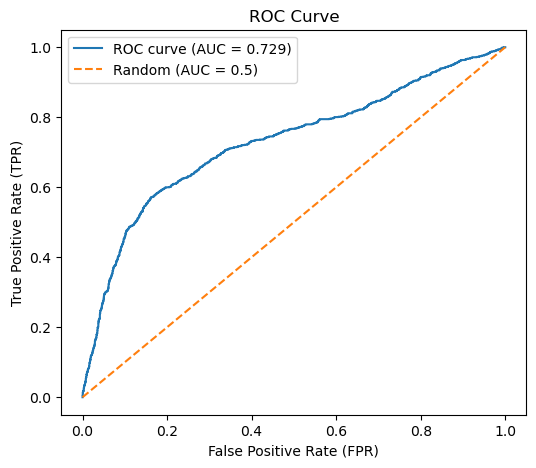

In [14]:
roc_curve_plot(y_test, y_proba)

#### ROC–AUC analysis

The ROC–AUC score (~0.73) suggests that the model separates classes reasonably well and performs significantly better than random guessing (AUC = 0.5).

However, the dataset is imbalanced (the majority class is non-default).
Because of this, the False Positive Rate (FPR) can remain relatively low even when the model makes a substantial number of mistakes on the minority class.

Since

$$FPR = \frac{FP}{FP + TN}$$

and the number of true negatives (TN) is large, even many false positives may result in a small FPR.
This artificially keeps the ROC curve elevated and increases the area under the curve.

From the shape of the curve we also observe that as the threshold increases, the model becomes more conservative and starts missing many positive cases (defaults). This means recall decreases significantly relative to classification errors.

Therefore, while ROC–AUC indicates acceptable ranking ability, it may overestimate practical usefulness in this imbalanced credit-risk setting.

### Precision-Recall curve

The Precision-Recall curve shows the trade-off between precision and recall across different classification thresholds.

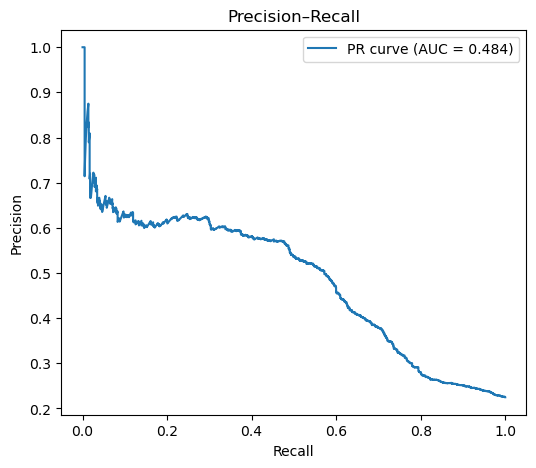

In [15]:
precision_recall_curve_plot(y_test, y_proba)

#### Precision-Recall analysis

The Precision–Recall curve shows how the trade-off between precision and recall changes as the decision threshold varies.

As the threshold decreases (moving right along the Recall axis), the model classifies more clients as defaulters.
This increases recall, but precision gradually declines, since more non-defaulters are incorrectly labeled as positive.

Key observations:
- The model achieves relatively high precision at low recall levels.
- As recall increases, precision decreases smoothly rather than collapsing abruptly.
- The curve suggests that the model captures meaningful signal, but cannot simultaneously maintain both very high precision and very high recall.

Overall, the behavior reflects the inherent difficulty of separating defaulters from non-defaulters in an imbalanced dataset. Improving sensitivity to the positive class inevitably introduces more false positives, highlighting the fundamental trade-off in binary classification.

### Cost history curve

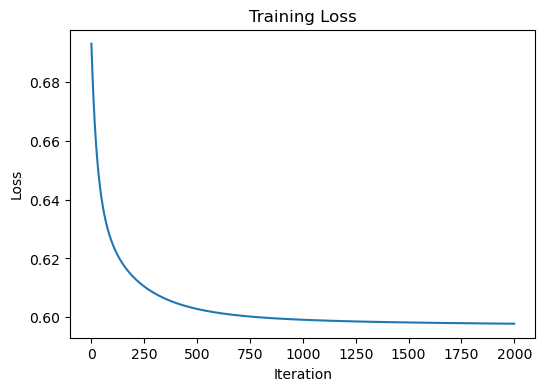

In [16]:
plt.figure(figsize=(6,4))
plt.plot(model.cost_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

#### Interpretation

The training loss decreases smoothly and monotonically over iterations, indicating stable convergence of gradient descent.

The chosen learning rate **alpha = 0.01** provides fast initial error reduction wint no signs of divergence or instability.

### Confusion matrix

The confusion matrix summarizes the model’s classification results into four components: True Negatives (Top-Left), False Positives (Top-Right),False Negatives (Bottom-Left), True Positives (Bottom-Right)

This representation allows us to analyze prediction behavior beyond aggregate metrics such as accuracy or F1-score.

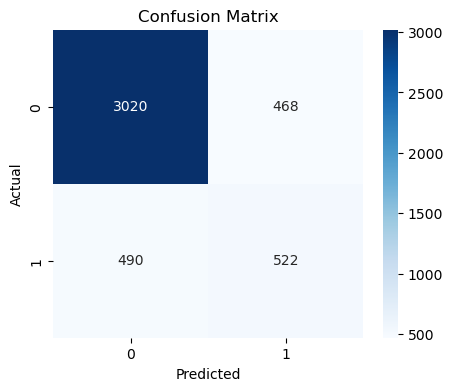

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#### Confusion matrix analysis 

The number of false positives **(FP = 468)** and false negatives **(FN = 490)** is very close.  
This indicates that class balancing worked as intended: the model treats errors on both classes more symmetrically.

However, true negatives **(TN = 3020)** still significantly exceed true positives **(TP = 522)**.  
Even though the dataset imbalance is partially compensated during training, the model still predicts class 0 more confidently and more frequently.

This suggests that the limitation is no longer threshold tuning or weighting, but rather the available feature signal.  
The model has improved fairness between classes, but the data still favors better separation of non-default clients.

## Sklearn implementation
For the sklearn comparison, we used the **lbfgs** solver, which is a quasi-Newton optimization method.  
It converges faster and more stably than standard gradient descent and does not require manual tuning of the learning rate, making it a strong default choice for logistic regression with L2 regularization.

To apply our previously selected decision threshold (0.6), we manually converted predicted probabilities into class labels

In [18]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    solver="lbfgs" #L-BFGS method
)
sk_model.fit(X_train, y_train)

y_pred_sk = sk_model.predict(X_test)
y_proba = sk_model.predict_proba(X_test)[:, 1]
y_pred_custom = (y_proba >= 0.6).astype(int)   # applying previously chosen threshold

print("Precision:", precision_score(y_test, y_pred_custom))
print("Recall:", recall_score(y_test, y_pred_custom))
print("F1:", f1_score(y_test, y_pred_custom))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Precision: 0.5120370370370371
Recall: 0.5464426877470355
F1: 0.52868068833652
ROC-AUC: 0.7300534356075716


#### Results and interpretation

Using the tuned threshold (0.6), the sklearn model achieves a balanced trade-off between precision and recall, resulting in an F1-score of ≈0.53.

The ROC-AUC remains around 0.73, indicating that the model has good ranking ability and can reasonably distinguish defaulters from non-defaulters across thresholds.

## Conclusion

The implemented Logistic Regression model achieved an ROC–AUC of approximately 0.73 on the test set.

Throughout the project, the model was developed fully from scratch using batch gradient descent. The following improvements were systematically applied:
- Z-score feature scaling (fitted on training data only)
- One-hot encoding for categorical variables
- Feature engineering (row-wise ratios, average delays, bill growth dynamics)
- Balanced class weighting to address class imbalance
- L2 regularization
- Learning rate tuning
- L2 strength tuning
- Threshold tuning based on F1-score
- Evaluation using ROC–AUC, Precision–Recall curves, and Confusion Matrix

Using these optimization and evaluation strategies, the final model demonstrates a clear improvement over the initial baseline configuration.

Importantly, the performance of the custom implementation is very close to Scikit-learn’s LogisticRegression, confirming both the correctness of the mathematical implementation and the effectiveness of the applied improvements.

Given the chosen evaluation framework (ROC–AUC for model selection and F1-score for threshold tuning), and considering that the model is fundamentally linear, the achieved results can be considered strong and consistent. While the model cannot capture complex non-linear interactions or temporal dependencies in repayment behavior, it provides a transparent, interpretable, and well-validated baseline for credit risk classification.